# Vancouver Takeoff Data Source Code

## Imports

In [30]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob
import numpy as np

## File Readings and Dataframe Creation

In [31]:
%%time
# Flights from Apr 16 to May 23

subfolders = [f.path for f in os.scandir('data/vancouver/flight/') if f.is_dir()] #Scans Directory
total_subfolders = len(subfolders)

# Stores a csv cols into a list
df_time_list = []
df_kw_list = []
df_alt_list = []
df_soc_list = []
df_oat_list = []

# Iterates and read each csv
for i, subfolder in enumerate(subfolders):
    csv_files = glob.glob(os.path.join(subfolder, '*.csv'))
    print(f"\rProcessing file {subfolder} [{round((i+1) / total_subfolders * 100)}%]", end='', flush = True) #Status Print
    if csv_files:
        # Reads the first csv file in each flight folder
        main_csv = csv_files[0]
        with open(main_csv) as f:
            total_rows = sum(1 for line in f)
        # Skips every 10 rows for efficiency (1 sec iterations estimate)
        skip_rows = [i for i in range(1, total_rows) if i % 10 != 0]
   
    df_csv = pd.read_csv(main_csv,skiprows=skip_rows)
    df_time_list.append(df_csv[" time(min)"])
    df_kw_list.append(df_csv[" motor power"])
    df_soc_list.append(df_csv[" bat 1 soc"])
    df_oat_list.append(df_csv[" OAT"])
    # Calibrates alt to ground alt and converts m to ft
    df_csv[" PRESSURE_ALT"] = (df_csv[" PRESSURE_ALT"]-df_csv[" PRESSURE_ALT"].iloc[-1])*3.28084
    df_csv[" PRESSURE_ALT"] = df_csv[" PRESSURE_ALT"].where(df_csv[" PRESSURE_ALT"]>=0, 0)
    df_alt_list.append(df_csv[" PRESSURE_ALT"])
    
# Main df
df_power = pd.DataFrame({"time": df_time_list, "kw": df_kw_list, "alt": df_alt_list, "soc": df_soc_list, "oat": df_oat_list})
print('') 

Processing file data/vancouver/flight/csv-24893-5865 [6%]

Processing file data/vancouver/flight/csv-25433-6054 [100%]
CPU times: total: 703 ms
Wall time: 2.92 s


## Data Visualizations

### Altitude Data From All Flights

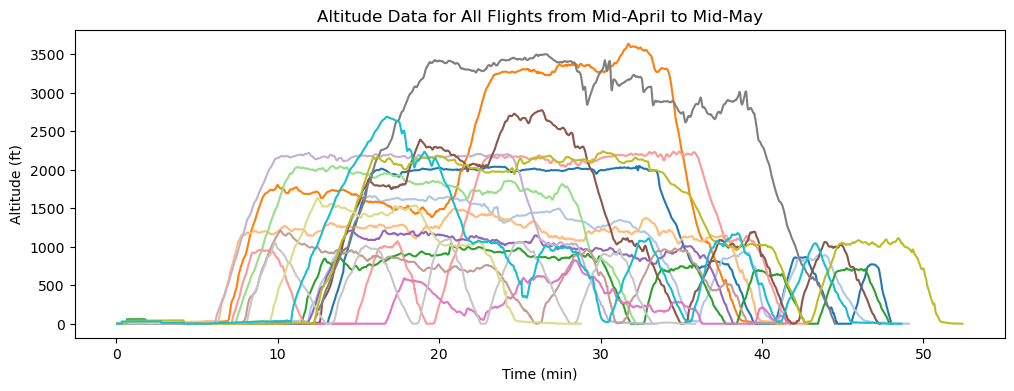

CPU times: total: 172 ms
Wall time: 332 ms


In [32]:
%%time
colormap = plt.colormaps['tab20']
plt.figure(figsize=(12, 4))
for i, subfolder in enumerate(subfolders):
    plt.plot(df_power["time"][i], df_power["alt"][i],color=colormap(i / total_subfolders))
    #plt.plot(df_power["kw"][i])

plt.xlabel('Time (min)')
plt.ylabel('Altitude (ft)')
plt.title('Altitude Data for All Flights from Mid-April to Mid-May')


plt.show()

### Circuit-Filtered Altitude Data 

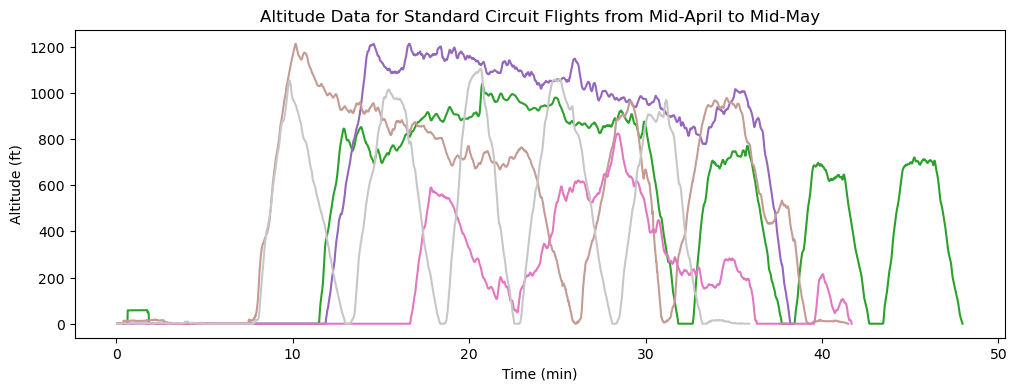

CPU times: total: 109 ms
Wall time: 336 ms


In [33]:
%%time
colormap = plt.colormaps['tab20']
plt.figure(figsize=(12, 4))
for i, subfolder in enumerate(subfolders):
    if df_power["alt"][i].max() < 1400:
        plt.plot(df_power["time"][i], df_power["alt"][i],color=colormap(i / total_subfolders))


plt.xlabel('Time (min)')
plt.ylabel('Altitude (ft)')
plt.title('Altitude Data for Standard Circuit Flights from Mid-April to Mid-May')
plt.show()

### Takeoff-Filtered Altitude Data

Processing file data/vancouver/flight/csv-25433-6054 [100%]
Average Slope of Altitude per Time: 582.585 ft/min
Average Slope of Time per Altitude: 0.6 min/300 ft
Plotting...


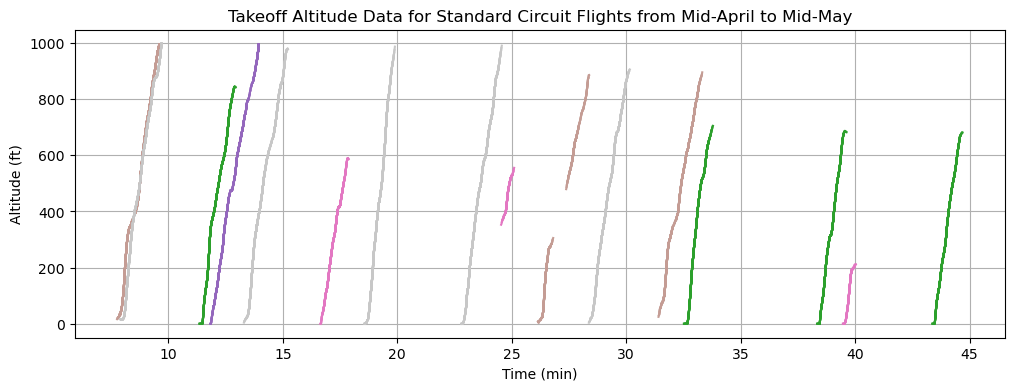

CPU times: total: 672 ms
Wall time: 2.19 s


In [34]:
%%time
cell_diff = 20
total_subfolders = len(subfolders)
colormap = plt.colormaps['tab20']
plt.figure(figsize=(12, 4))

slopes_ft_per_min = []

for i, subfolder in enumerate(subfolders):
    print(f"\rProcessing file {subfolder} [{round((i+1) / total_subfolders * 100)}%]", end='', flush = True)
    if df_power["alt"][i].max() < 1300:
        # Calculates the slope of cells 100 cells away from each other
        alt_diff = df_power["alt"][i].diff(periods=cell_diff)
        time_diff = df_power["time"][i].diff(periods=cell_diff)
        temp_alt_diff = df_power["alt"][i].diff(periods=10)
        alt_diff[temp_alt_diff < 0] = 0
        slope = alt_diff / time_diff 
        # Find the indices where slope is over 450
        high_slope_indices = slope[slope > 400].index
    
        if not high_slope_indices.empty:
            # Plots the data inbtwn data sufficient slope
            for idx in high_slope_indices:
                start_idx = max(0, idx - cell_diff + 1)
                end_idx = min(len(df_power["alt"][i]), idx + 1)
                # Stops indexing at 1000 when end index is greater than 1000
                if df_power["alt"][i][end_idx] > 1000:
                    end_idx = np.argmax(df_power["alt"][i] > 1000)
                alt_data = df_power["alt"][i][start_idx:end_idx]
                time_data = df_power["time"][i][start_idx:end_idx]
                plt.plot(time_data, alt_data, color=colormap(i / total_subfolders))

                # Finds average slope
                diff_alt_data = np.diff(alt_data)
                diff_time_data = np.diff(time_data)
                valid_indices = np.where(diff_time_data != 0)[0]
                slope_ft_per_min = diff_alt_data[valid_indices] / diff_time_data[valid_indices]
                slopes_ft_per_min.extend(slope_ft_per_min)

print('')
average_slope_soc_per_ft = abs(np.mean(slopes_ft_per_min))
print(f"Average Slope of Altitude per Time: {round(average_slope_soc_per_ft,3)} ft/min")
print(f"Average Slope of Time per Altitude: {round(1/average_slope_soc_per_ft,3)*300} min/300 ft")
print("Plotting...")
plt.xlabel('Time (min)')
plt.ylabel('Altitude (ft)')
plt.title('Takeoff Altitude Data for Standard Circuit Flights from Mid-April to Mid-May')
plt.grid(True)
plt.show()


### Takeoff Power Data

Processing file data/vancouver/flight/csv-25433-6054 [100%]
Plotting...


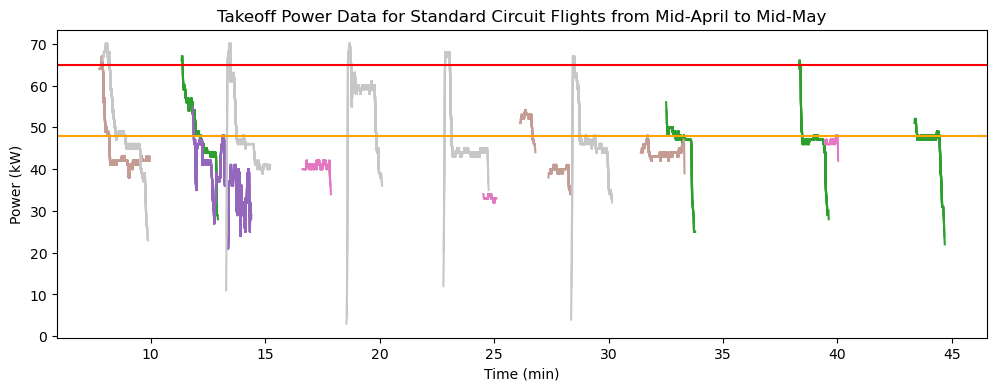

CPU times: total: 734 ms
Wall time: 1.98 s


In [35]:
%%time
cell_diff = 20
total_subfolders = len(subfolders)
colormap = plt.colormaps['tab20']
plt.figure(figsize=(12, 4))

for i, subfolder in enumerate(subfolders):
    print(f"\rProcessing file {subfolder} [{round((i+1) / total_subfolders * 100)}%]", end='', flush = True)
    if df_power["alt"][i].max() < 1400:
        # Calculates the slope of cells 100 cells away from each other
        alt_diff = df_power["alt"][i].diff(periods=cell_diff)
        time_diff = df_power["time"][i].diff(periods=cell_diff)
        temp_alt_diff = df_power["alt"][i].diff(periods=10)
        alt_diff[temp_alt_diff < 0] = 0
        slope = alt_diff / time_diff 
    
        # Find the indices where slope is over 450
        high_slope_indices = slope[slope > 400].index
    
        if not high_slope_indices.empty:
            # Plots the data inbtwn data sufficient slope
            for idx in high_slope_indices:
                start_idx = max(0, idx - cell_diff + 1)
                end_idx = min(len(df_power["alt"][i]), idx + 1)
                time_data = df_power["time"][i][start_idx:end_idx]
                alt_data = df_power["kw"][i][start_idx:end_idx]
                plt.plot(time_data, alt_data, color=colormap(i / total_subfolders))

print('')
print("Plotting...")

plt.axhline(y=65, color='r')
plt.axhline(y=48, color='orange')
plt.xlabel('Time (min)')
plt.ylabel('Power (kW)')
plt.title('Takeoff Power Data for Standard Circuit Flights from Mid-April to Mid-May')
plt.show()


Processing file data/vancouver/flight/csv-25433-6054 [100%]
Plotting...


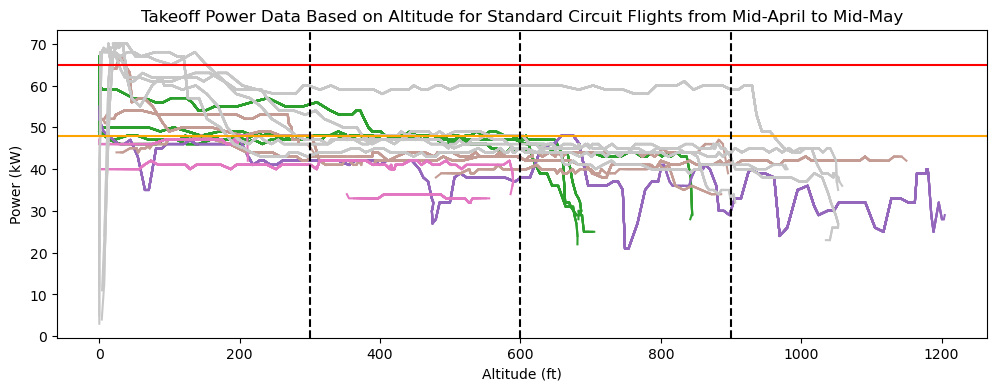

CPU times: total: 672 ms
Wall time: 2.04 s


In [36]:
%%time
cell_diff = 20
total_subfolders = len(subfolders)
colormap = plt.colormaps['tab20']
plt.figure(figsize=(12, 4))

for i, subfolder in enumerate(subfolders):
    print(f"\rProcessing file {subfolder} [{round((i+1) / total_subfolders * 100)}%]", end='', flush = True)
    if df_power["alt"][i].max() < 1300:
        # Calculates the slope of cells 100 cells away from each other
        alt_diff = df_power["alt"][i].diff(periods=cell_diff)
        time_diff = df_power["time"][i].diff(periods=cell_diff)
        temp_alt_diff = df_power["alt"][i].diff(periods=10)
        alt_diff[temp_alt_diff < 0] = 0
        slope = alt_diff / time_diff 
    
        # Find the indices where slope is over 450
        high_slope_indices = slope[slope > 400].index
    
        if not high_slope_indices.empty:
            # Plots the data inbtwn data sufficient slope
            for idx in high_slope_indices:
                start_idx = max(0, idx - cell_diff + 1)
                end_idx = min(len(df_power["alt"][i]), idx + 1)
                time_data = df_power["alt"][i][start_idx:end_idx]
                alt_data = df_power["kw"][i][start_idx:end_idx]
                plt.plot(time_data, alt_data, color=colormap(i / total_subfolders))

print('')
print("Plotting...")

plt.axhline(y=65, color='r')
plt.axhline(y=48, color='orange')
plt.axvline(x=300, color='black', linestyle='--')
plt.axvline(x=600, color='black', linestyle='--')
plt.axvline(x=900, color='black', linestyle='--')
plt.xlabel('Altitude (ft)')
plt.ylabel('Power (kW)')
plt.title('Takeoff Power Data Based on Altitude for Standard Circuit Flights from Mid-April to Mid-May')
plt.show()


### Takeoff SoC Data

Processing file data/vancouver/flight/csv-25030-5911 [29%]

Processing file data/vancouver/flight/csv-25433-6054 [100%]
Average Slope of SoC per Altitude: 11.277%/1000 ft
Plotting...


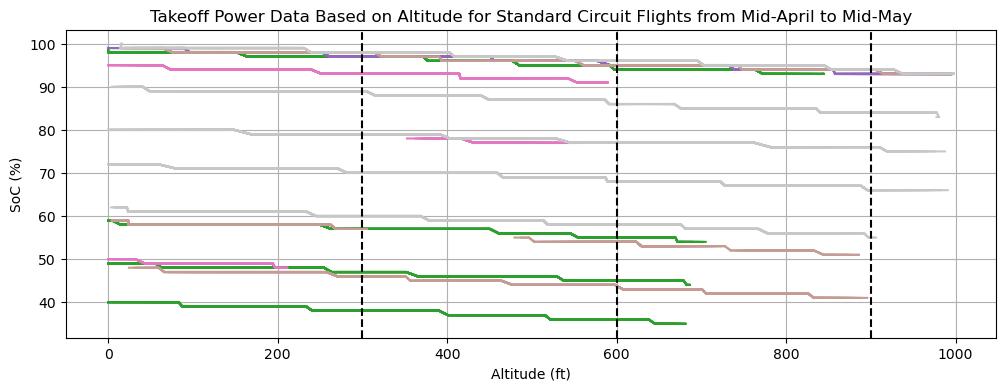

CPU times: total: 672 ms
Wall time: 2.24 s


In [37]:
%%time
cell_diff = 20
total_subfolders = len(subfolders)
colormap = plt.colormaps['tab20']
plt.figure(figsize=(12, 4))

slopes_soc_per_ft = []

for i, subfolder in enumerate(subfolders):
    print(f"\rProcessing file {subfolder} [{round((i+1) / total_subfolders * 100)}%]", end='', flush = True)
    if df_power["alt"][i].max() < 1300:
        # Calculates the slope of cells 100 cells away from each other
        alt_diff = df_power["alt"][i].diff(periods=cell_diff)
        time_diff = df_power["time"][i].diff(periods=cell_diff)
        temp_alt_diff = df_power["alt"][i].diff(periods=10)
        alt_diff[temp_alt_diff < 0] = 0
        slope = alt_diff / time_diff 
        # Find the indices where slope is over 450
        high_slope_indices = slope[slope > 400].index
    
        if not high_slope_indices.empty:
            # Plots the data inbtwn data sufficient slope
            for idx in high_slope_indices:
                start_idx = max(0, idx - cell_diff + 1)
                end_idx = min(len(df_power["alt"][i]), idx + 1)
                if df_power["alt"][i][end_idx] > 1000:
                    end_idx = np.argmax(df_power["alt"][i] > 1000)
                time_data = df_power["alt"][i][start_idx:end_idx]
                soc_data = df_power["soc"][i][start_idx:end_idx]
                plt.plot(time_data, soc_data, color=colormap(i / total_subfolders))

                diff_soc_data = np.diff(soc_data)
                diff_time_data = np.diff(time_data)
                valid_indices = np.where(diff_time_data != 0)[0]
                slope_soc_per_ft = diff_soc_data[valid_indices] / diff_time_data[valid_indices]
                slopes_soc_per_ft.extend(slope_soc_per_ft)

print('')
average_slope_soc_per_ft = abs(np.mean(slopes_soc_per_ft))*1000
print(f"Average Slope of SoC per Altitude: {round(average_slope_soc_per_ft,3)}%/1000 ft")
print("Plotting...")
plt.axvline(x=300, color='black', linestyle='--')
plt.axvline(x=600, color='black', linestyle='--')
plt.axvline(x=900, color='black', linestyle='--')
plt.xlabel('Altitude (ft)')
plt.ylabel('SoC (%)')
plt.title('Takeoff Power Data Based on Altitude for Standard Circuit Flights from Mid-April to Mid-May')
plt.grid(True)
plt.show()


Processing file data/vancouver/flight/csv-25433-6054 [100%]
Plotting...


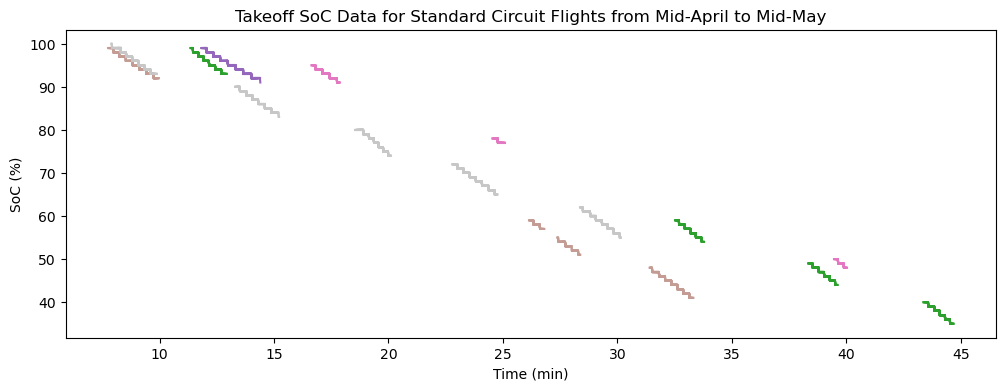

CPU times: total: 688 ms
Wall time: 1.76 s


In [38]:
%%time
cell_diff = 20
total_subfolders = len(subfolders)
colormap = plt.colormaps['tab20']
plt.figure(figsize=(12, 4))

for i, subfolder in enumerate(subfolders):
    print(f"\rProcessing file {subfolder} [{round((i+1) / total_subfolders * 100)}%]", end='', flush = True)
    if df_power["alt"][i].max() < 1300:
        # Calculates the slope of cells 100 cells away from each other
        alt_diff = df_power["alt"][i].diff(periods=cell_diff)
        time_diff = df_power["time"][i].diff(periods=cell_diff)
        temp_alt_diff = df_power["alt"][i].diff(periods=10)
        alt_diff[temp_alt_diff < 0] = 0
        slope = alt_diff / time_diff 
    
        # Find the indices where slope is over 450
        high_slope_indices = slope[slope > 400].index
    
        if not high_slope_indices.empty:
            # Plots the data inbtwn data sufficient slope
            for idx in high_slope_indices:
                start_idx = max(0, idx - cell_diff + 1)
                end_idx = min(len(df_power["alt"][i]), idx + 1)
                time_data = df_power["time"][i][start_idx:end_idx]
                alt_data = df_power["soc"][i][start_idx:end_idx]
                plt.plot(time_data, alt_data, color=colormap(i / total_subfolders))

print('')
print("Plotting...")
plt.xlabel('Time (min)')
plt.ylabel('SoC (%)')
plt.title('Takeoff SoC Data for Standard Circuit Flights from Mid-April to Mid-May')
plt.show()


### Takeoff OAT Data

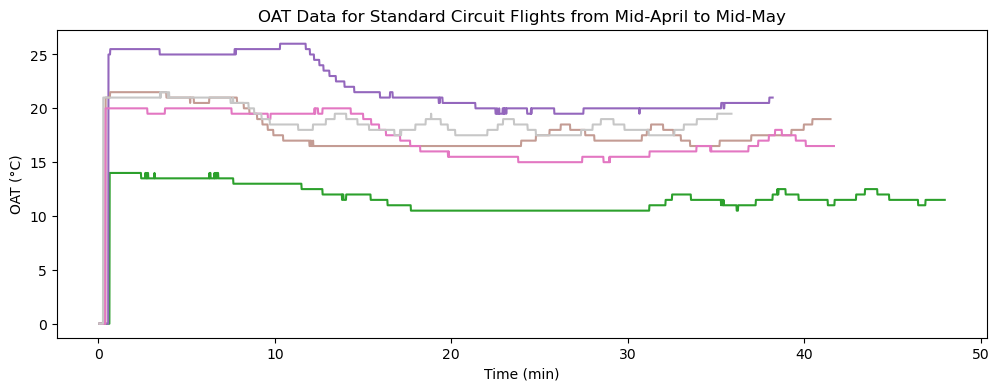

CPU times: total: 93.8 ms
Wall time: 313 ms


In [39]:
%%time
colormap = plt.colormaps['tab20']
plt.figure(figsize=(12, 4))
for i, subfolder in enumerate(subfolders):
    if df_power["alt"][i].max() < 1400:
        first_non_zero = df_power["oat"][i].loc[df_power["oat"][i] != 0].iloc[0]
        df_power.loc[df_power["oat"][i] == 0, 'A'] = first_non_zero
        plt.plot(df_power["time"][i], df_power["oat"][i],color=colormap(i / total_subfolders))


plt.xlabel('Time (min)')
plt.ylabel('OAT (°C)')
plt.title('OAT Data for Standard Circuit Flights from Mid-April to Mid-May')
plt.show()

Processing file data/vancouver/flight/csv-25433-6054 [100%]
Plotting...


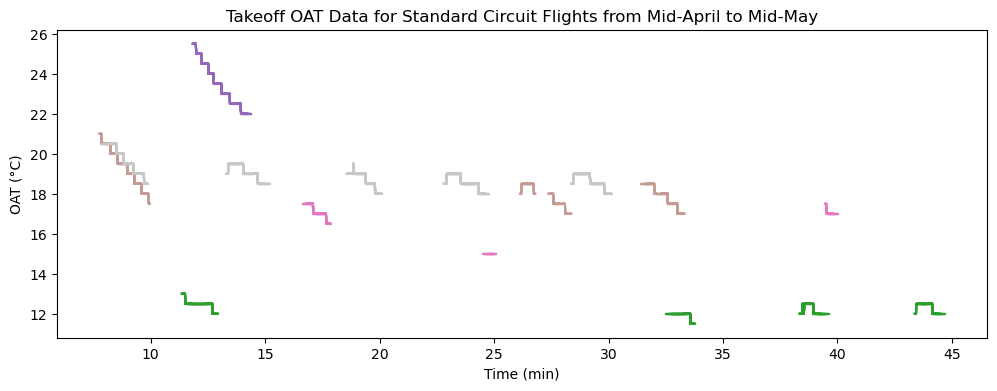

CPU times: total: 797 ms
Wall time: 2 s


In [40]:
%%time
cell_diff = 20
total_subfolders = len(subfolders)
colormap = plt.colormaps['tab20']
plt.figure(figsize=(12, 4))

for i, subfolder in enumerate(subfolders):
    print(f"\rProcessing file {subfolder} [{round((i+1) / total_subfolders * 100)}%]", end='', flush = True)
    if df_power["alt"][i].max() < 1300:
        # Calculates the slope of cells 100 cells away from each other
        alt_diff = df_power["alt"][i].diff(periods=cell_diff)
        time_diff = df_power["time"][i].diff(periods=cell_diff)
        temp_alt_diff = df_power["alt"][i].diff(periods=10)
        alt_diff[temp_alt_diff < 0] = 0
        slope = alt_diff / time_diff 
    
        # Find the indices where slope is over 450
        high_slope_indices = slope[slope > 400].index
    
        if not high_slope_indices.empty:
            # Plots the data inbtwn data sufficient slope
            for idx in high_slope_indices:
                start_idx = max(0, idx - cell_diff + 1)
                end_idx = min(len(df_power["alt"][i]), idx + 1)
                time_data = df_power["time"][i][start_idx:end_idx]
                alt_data = df_power["oat"][i][start_idx:end_idx]
                plt.plot(time_data, alt_data, color=colormap(i / total_subfolders))

print('')
print("Plotting...")
plt.xlabel('Time (min)')
plt.ylabel('OAT (°C)')
plt.title('Takeoff OAT Data for Standard Circuit Flights from Mid-April to Mid-May')
plt.show()
